<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Libraries" data-toc-modified-id="Load-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Libraries</a></span></li><li><span><a href="#Set-Parameters" data-toc-modified-id="Set-Parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Set Parameters</a></span></li><li><span><a href="#Prepare-Random-Data" data-toc-modified-id="Prepare-Random-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare Random Data</a></span></li><li><span><a href="#Prepare-DataFrame-to-Record-Simulation-Results" data-toc-modified-id="Prepare-DataFrame-to-Record-Simulation-Results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Prepare DataFrame to Record Simulation Results</a></span></li><li><span><a href="#Run-Simulation" data-toc-modified-id="Run-Simulation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Run Simulation</a></span></li><li><span><a href="#Fill-In-Derived-Data" data-toc-modified-id="Fill-In-Derived-Data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Fill-In Derived Data</a></span></li><li><span><a href="#Analyse-Simulation-Results" data-toc-modified-id="Analyse-Simulation-Results-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Analyse Simulation Results</a></span></li><li><span><a href="#References" data-toc-modified-id="References-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Load Libraries

In [1]:
#!pip install simpy

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as ss
import math
import numpy as np
import random

import simpy

# Set Parameters

In [3]:
INTERVAL_CUSTOMERS=5 # average time between events
PROCESSING_TIME=3  # average processing time in the bank
CUSTOMERS=40 # number of customers 

# Prepare Random Data

In [4]:
random.seed(42)

In [5]:
# Create a DataFrame with input parameters
cdata = pd.DataFrame()
cdata['arr'] = [ random.expovariate(1.0/INTERVAL_CUSTOMERS) for i in range(CUSTOMERS) ]
cdata['proc'] = [ random.expovariate(1.0/PROCESSING_TIME) for i in range(CUSTOMERS) ]

In [6]:
cdata.head()

,arr,proc
0,5.100301,3.657989
1,0.126644,0.140723
2,1.608120,0.775917
3,1.262931,1.024886
4,6.667963,0.249467


In [7]:
cdata.describe()

,arr,proc
count,40.000000,40.000000
mean,4.624493,2.601835
std,4.217703,2.862498
min,0.032600,0.097880
25%,1.242245,0.791338
50%,3.975955,1.374283
75%,6.573267,3.262806
max,18.081076,13.675819


In [8]:
def poissonPlot(data, title=None):
    μ = data.mean()
    n = data.count()
    max = math.ceil(data.max()/10)*10
    
    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(5)
    
    ax = fig.gca()
    ax.set_xlim(0, max)
    
    if title!=None:
        ax.set_title(title+" (n={:,})".format(n))
        
    data.hist(ax=ax, bins=max+1, density=True)

    x = [ i/10 for i in range(1, 10*max)]
    y = [ 1/μ*math.exp(-x/μ) for x in x]
    plt.plot(x, y, lw=3, color='red')
    print(y[0])
    ax.axvline(x=μ, color='red')
    plt.text(μ+0.2,0.9*y[0],'μ='+'%2.2f' % μ, color='red', fontsize=14)
    plt.grid(True)

0.21161413117902642


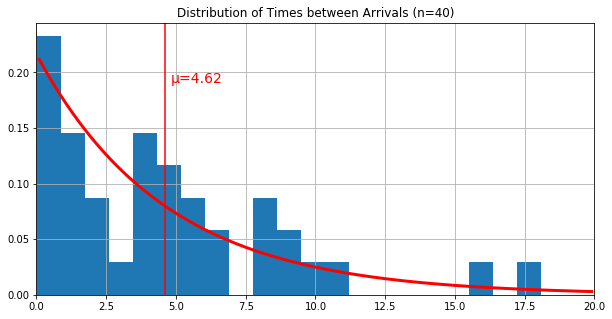

In [9]:
poissonPlot(cdata['arr'], title="Distribution of Times between Arrivals")

0.36985241283552334


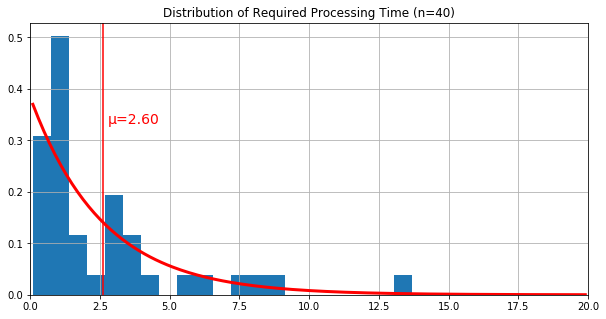

In [10]:
poissonPlot(cdata['proc'], title="Distribution of Required Processing Time")

# Prepare DataFrame to Record Simulation Results

In [11]:
# Prepare a DataFrame to record observations
sdata = pd.DataFrame()
sdata['arrived at'] = [None]*CUSTOMERS
sdata['ql at arrival'] = [None]*CUSTOMERS
sdata['ql at proc start'] = [None]*CUSTOMERS
sdata['proc started at'] = [None]*CUSTOMERS
sdata['proc finished at'] = [None]*CUSTOMERS 

In [12]:
sdata.head()

,arrived at,ql at arrival,ql at proc start,proc started at,proc finished at
0,None,None,None,None,None
1,None,None,None,None,None
2,None,None,None,None,None
3,None,None,None,None,None
4,None,None,None,None,None


# Run Simulation

Doc [simpy](https://simpy.readthedocs.io/en/latest/)

In [13]:
def source(env, n, counter):
    for i in range(n):
        t = cdata.at[i, 'arr']
        # wait until the next customer arrives...
        yield env.timeout(t)
        c = customer(env, i, counter)
        env.process(c)
        

In [14]:
def customer(env, i, counter):
    sdata.at[i, 'arrived at'] = env.now
    req = counter.request()
    sdata.at[i, 'ql at arrival'] = len(counter.queue)

    # Wait for the counter 
    yield req 
    
    # print(f"serving customer {i:d} at {env.now:6.2f}")
    sdata.at[i, 'proc started at'] = env.now
    sdata.at[i, 'ql at proc start'] = len(counter.queue)
    
    yield env.timeout(cdata.at[i, 'proc'])
    
    sdata.at[i, 'proc finished at'] = env.now
    
    counter.release(req)


In [15]:
env = simpy.Environment()

In [16]:
counter = simpy.Resource(env, capacity=1)

In [17]:
env.process(source(env, CUSTOMERS, counter))

<Process(source) object at 0x1a16cc3f10>

In [18]:
env.run()

# Fill-In Derived Data

In [19]:
sdata

,arrived at,ql at arrival,ql at proc start,proc started at,proc finished at
0,5.1003,0,0,5.1003,8.75829
1,5.22695,1,2,8.75829,8.89901
2,6.83507,2,1,8.89901,9.67493
3,8.098,3,0,9.67493,10.6998
4,14.766,0,0,14.766,15.0154
5,20.4118,0,0,20.4118,21.2068
6,31.5483,0,0,31.5483,31.8677
7,32.003,0,0,32.003,32.9801
8,34.7433,0,0,34.7433,37.7725
9,34.8945,1,1,37.7725,39.1341


In [20]:
sdata['wait time']=sdata['proc started at']-sdata['arrived at'] 
sdata['proc time']=sdata['proc finished at']-sdata['proc started at']
sdata['idle time']=sdata['proc started at']-sdata['proc finished at'].shift(1)
sdata.at[0, 'idle time']=sdata.at[0, 'proc started at']

In [21]:
sdata.head(10)

,arrived at,ql at arrival,ql at proc start,proc started at,proc finished at,wait time,proc time,idle time
0,5.1003,0,0,5.1003,8.75829,0,3.65799,5.1003
1,5.22695,1,2,8.75829,8.89901,3.53134,0.140723,0
2,6.83507,2,1,8.89901,9.67493,2.06395,0.775917,0
3,8.098,3,0,9.67493,10.6998,1.57693,1.02489,0
4,14.766,0,0,14.766,15.0154,0,0.249467,4.06614
5,20.4118,0,0,20.4118,21.2068,0,0.794988,5.3964
6,31.5483,0,0,31.5483,31.8677,0,0.319422,10.3415
7,32.003,0,0,32.003,32.9801,0,0.977081,0.135341
8,34.7433,0,0,34.7433,37.7725,0,3.0292,1.76315
9,34.8945,1,1,37.7725,39.1341,2.87795,1.3616,0


# Analyse Simulation Results

In [22]:
w = sdata['wait time']
print(f"Customers waited in average  {w.mean():5.2f}min.")
print(f"The minimum waiting time was {w.min():5.2f}min.")
print(f"the maximum waiting time was {w.max():5.2f}min.")

Customers waited in average   2.10min.
The minimum waiting time was  0.00min.
the maximum waiting time was 10.27min.


In [23]:
qt = 0
lastT = 0
Tenq = 0
Tdeq = 0
i, j = 0, 0
while i<len(sdata) and j<len(sdata):
    Tenq = sdata.at[i, 'arrived at']
    Tdeq = sdata.at[j, 'proc started at']
    if Tenq < Tdeq:
        ql = sdata.at[i, 'ql at arrival']
        qt += ql * (Tenq-lastT)
        lastT = Tenq
        i += 1
    elif Tdeq < Tenq:
        ql = sdata.at[i, 'ql at proc start']
        qt += (ql+1) * (Tdeq-lastT)
        lastT = Tdeq
        j += 1
    else:
        ql = sdata.at[i, 'ql at arrival']
        qt += ql * (Tdeq-lastT)
        lastT = Tdeq
        i += 1
        j += 1
        
while i<len(sdata):
    Tenq = sdata.at[i, 'arrived at']    
    ql = sdata.at[i, 'ql at arrival']
    qt += ql * (Tenq-lastT)
    lastT = Tenq
    i += 1
    
while j<len(sdata):
    Tdeq = sdata.at[j, 'proc started at']        
    ql = sdata.at[i, 'ql at proc start']
    qt += (ql+1) * (Tdeq-lastT)
    lastT = Tdeq
    j += 1
    
maxql = sdata['ql at arrival'].max()

print(f"The maximum queue length was: {maxql:d}.")
print(f"Average queue length was {qt / lastT:4.2f}.")

The maximum queue length was: 3.
Average queue length was 0.52.


In [24]:
proc_time=sdata['proc time'].sum()
idle_time=sdata['idle time'].sum()
total_time=proc_time+idle_time
print(f"Server utilisation was {100*proc_time/total_time:4.1f}% "
      f"over a total time of {total_time/60:4.1f} hours")

Server utilisation was 56.0% over a total time of  3.1 hours


# References

- [python math library]( https://docs.python.org/3/library/math.html)
- [matplotlib](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html)
- [pandas](https://pandas.pydata.org/pandas-docs/stable/)
- [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html)
- [simpy](https://simpy.readthedocs.io/en/latest/contents.html) 
    [.pdf](https://readthedocs.org/projects/simpy/downloads/pdf/latest/)
    [The In-Depth Manual (2.2)](https://pythonhosted.org/SimPy/Manuals/Manual.html)